In [6]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [7]:
#change the tickers here according to what's in the portfolio
tickers = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [8]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HSON    1259 non-null   float64
 1   ISSC    1259 non-null   float64
 2   KRNT    1259 non-null   float64
 3   RCII    1259 non-null   float64
 4   SAIA    1259 non-null   float64
 5   AMD     1259 non-null   float64
 6   EPAM    1259 non-null   float64
 7   ASML    1259 non-null   float64
 8   AUDC    1259 non-null   float64
 9   DSGX    1259 non-null   float64
 10  MGIC    1259 non-null   float64
 11  DHI     1259 non-null   float64
 12  LULU    1259 non-null   float64
 13  MBUU    1259 non-null   float64
 14  MCRI    1259 non-null   float64
 15  RUSHA   1259 non-null   float64
 16  CTLT    1259 non-null   float64
 17  IDXX    1259 non-null   float64
 18  BDSI    1259 non-null   float64
 19  MEDP    1259 non-null   float64
 20  MODV    1259 non-null   float64
 21  RGEN    1259 non-nu

## Function that saves dataframe to CSV

In [9]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [10]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [11]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [12]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [13]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [14]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [15]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [16]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [17]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [18]:
#change to the list of stocks we using
port_list = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

#add in the weightage of stocks
port_shares = [0.005745333,0.002319111,0.009586667,0.005848889,0.020944444,0.005100889,0.011048444,0.011962222,
               0.007137333,0.006581778,0.002614222,0.008,0.024824444,0.00456,0.000948889,0.006111556,0.000473778,
               0.016528,0.003252,0.004186222,0.004289333,0.015715111,0.013029333,0.018354667,0.013060444,0.012284889,
               0.032159556,0.044444444,0.044444444,0.003561333,0.040883111,0.6]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.081584,0.006940,0.127023,0.062365,0.940406,0.058303,0.703344,1.261140,0.043852,0.139863,...,0.105267,0.162745,1.671105,4.626770,1.955698,0.013106,0.347506,1.1664,19.444942,NaN
2017-01-04,0.084456,0.007000,0.123668,0.063008,0.943547,0.058303,0.711078,1.255088,0.043320,0.141179,...,0.099259,0.175146,1.717081,4.633347,1.973860,0.013996,0.347098,1.1682,19.619364,0.008970
2017-01-05,0.083882,0.007219,0.119833,0.060061,0.920508,0.057334,0.715387,1.270160,0.041856,0.139205,...,0.093774,0.172666,1.707269,4.571966,1.968064,0.013889,0.349551,1.1178,19.456278,-0.008313
2017-01-06,0.082733,0.007180,0.121271,0.057596,0.939987,0.057742,0.738809,1.268790,0.042654,0.139863,...,0.093643,0.175973,1.690168,4.538645,1.960721,0.013711,0.345053,1.1532,19.492729,0.001873
2017-01-09,0.080435,0.007479,0.127982,0.057918,0.923650,0.058609,0.738478,1.284433,0.041989,0.139534,...,0.092729,0.173375,1.671946,4.515409,1.918987,0.014103,0.348324,1.1286,19.353795,-0.007127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.160008,0.014866,1.470211,0.287765,6.975547,0.787373,7.700765,9.706506,0.248736,0.538521,...,0.331605,0.514986,3.735086,17.038221,3.228535,0.066241,4.004501,0.7512,89.457408,0.022419
2021-12-28,0.161903,0.015306,1.461487,0.286186,6.915646,0.781201,7.537249,9.626838,0.247023,0.539706,...,0.327164,0.514986,3.664643,17.099111,3.224566,0.064674,3.951353,0.7470,88.717690,-0.008269
2021-12-29,0.161214,0.015167,1.479990,0.288701,7.024976,0.756258,7.489078,9.593463,0.248451,0.542602,...,0.333172,0.514863,3.678732,17.108889,3.215746,0.064496,3.951353,0.7764,88.943152,0.002541


## Get old data for portfolio

In [19]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.081584,0.006940,0.127023,0.062365,0.940406,0.058303,0.703344,1.261140,0.043852,0.139863,...,0.105267,0.162745,1.671105,4.626770,1.955698,0.013106,0.347506,1.1664,19.444942,NaN
2017-01-04,0.084456,0.007000,0.123668,0.063008,0.943547,0.058303,0.711078,1.255088,0.043320,0.141179,...,0.099259,0.175146,1.717081,4.633347,1.973860,0.013996,0.347098,1.1682,19.619364,0.008970
2017-01-05,0.083882,0.007219,0.119833,0.060061,0.920508,0.057334,0.715387,1.270160,0.041856,0.139205,...,0.093774,0.172666,1.707269,4.571966,1.968064,0.013889,0.349551,1.1178,19.456278,-0.008313
2017-01-06,0.082733,0.007180,0.121271,0.057596,0.939987,0.057742,0.738809,1.268790,0.042654,0.139863,...,0.093643,0.175973,1.690168,4.538645,1.960721,0.013711,0.345053,1.1532,19.492729,0.001873
2017-01-09,0.080435,0.007479,0.127982,0.057918,0.923650,0.058609,0.738478,1.284433,0.041989,0.139534,...,0.092729,0.173375,1.671946,4.515409,1.918987,0.014103,0.348324,1.1286,19.353795,-0.007127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.160008,0.014866,1.470211,0.287765,6.975547,0.787373,7.700765,9.706506,0.248736,0.538521,...,0.331605,0.514986,3.735086,17.038221,3.228535,0.066241,4.004501,0.7512,89.457408,0.022419
2021-12-28,0.161903,0.015306,1.461487,0.286186,6.915646,0.781201,7.537249,9.626838,0.247023,0.539706,...,0.327164,0.514986,3.664643,17.099111,3.224566,0.064674,3.951353,0.7470,88.717690,-0.008269
2021-12-29,0.161214,0.015167,1.479990,0.288701,7.024976,0.756258,7.489078,9.593463,0.248451,0.542602,...,0.333172,0.514863,3.678732,17.108889,3.215746,0.064496,3.951353,0.7764,88.943152,0.002541


## Forecasting

In [20]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [21]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [22]:
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.081584,0.006940,0.127023,0.062365,0.940406,0.058303,0.703344,1.261140,0.043852,0.139863,...,0.105267,0.162745,1.671105,4.626770,1.955698,0.013106,0.347506,1.1664,19.444942,NaN
2017-01-04,0.084456,0.007000,0.123668,0.063008,0.943547,0.058303,0.711078,1.255088,0.043320,0.141179,...,0.099259,0.175146,1.717081,4.633347,1.973860,0.013996,0.347098,1.1682,19.619364,0.008970
2017-01-05,0.083882,0.007219,0.119833,0.060061,0.920508,0.057334,0.715387,1.270160,0.041856,0.139205,...,0.093774,0.172666,1.707269,4.571966,1.968064,0.013889,0.349551,1.1178,19.456278,-0.008313
2017-01-06,0.082733,0.007180,0.121271,0.057596,0.939987,0.057742,0.738809,1.268790,0.042654,0.139863,...,0.093643,0.175973,1.690168,4.538645,1.960721,0.013711,0.345053,1.1532,19.492729,0.001873
2017-01-07,0.082733,0.007180,0.121271,0.057596,0.939987,0.057742,0.738809,1.268790,0.042654,0.139863,...,0.093643,0.175973,1.690168,4.538645,1.960721,0.013711,0.345053,1.1532,19.492729,0.001873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.160008,0.014866,1.470211,0.287765,6.975547,0.787373,7.700765,9.706506,0.248736,0.538521,...,0.331605,0.514986,3.735086,17.038221,3.228535,0.066241,4.004501,0.7512,89.457408,0.022419
2021-12-28,0.161903,0.015306,1.461487,0.286186,6.915646,0.781201,7.537249,9.626838,0.247023,0.539706,...,0.327164,0.514986,3.664643,17.099111,3.224566,0.064674,3.951353,0.7470,88.717690,-0.008269
2021-12-29,0.161214,0.015167,1.479990,0.288701,7.024976,0.756258,7.489078,9.593463,0.248451,0.542602,...,0.333172,0.514863,3.678732,17.108889,3.215746,0.064496,3.951353,0.7764,88.943152,0.002541


In [23]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [24]:
tot_port_df

,Total
Date,
2017-01-03,19.444942
2017-01-04,19.619364
2017-01-05,19.456278
2017-01-06,19.492729
2017-01-07,19.492729
...,...
2021-12-27,89.457408
2021-12-28,88.717690
2021-12-29,88.943152


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


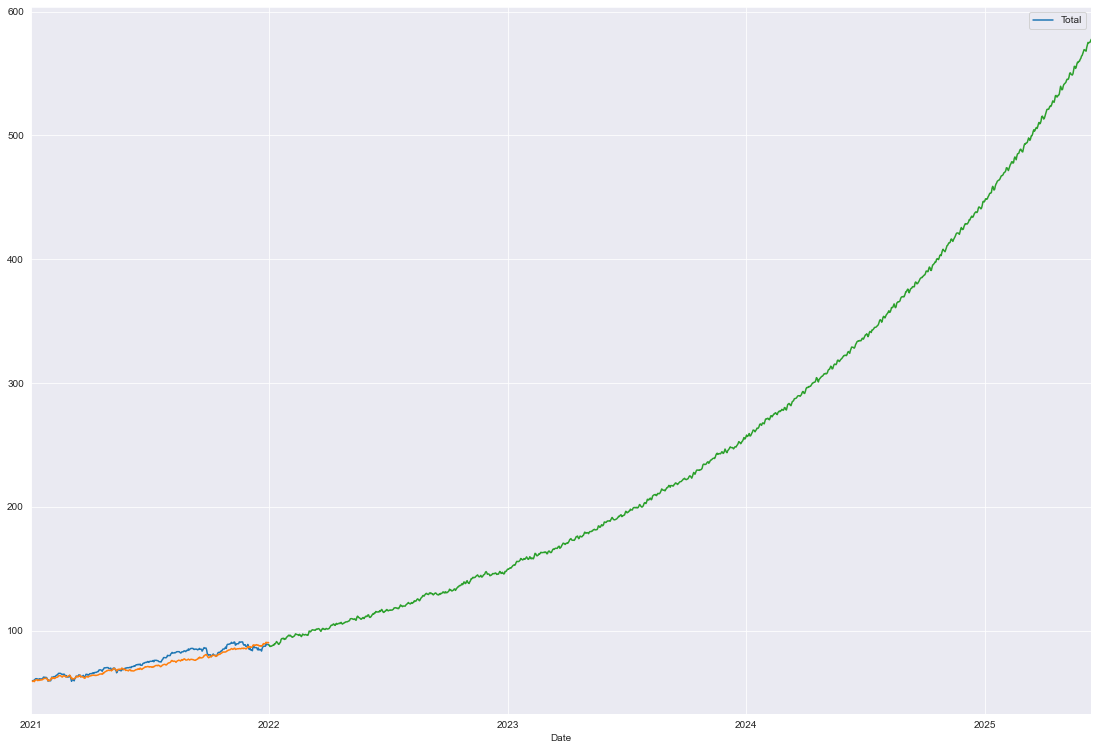

In [25]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [26]:
forecast

2021-12-31     88.595554
2022-01-01     88.093174
2022-01-02     87.228311
2022-01-03     87.466712
2022-01-04     87.459093
                 ...    
2025-06-09    574.765308
2025-06-10    575.037820
2025-06-11    575.206737
2025-06-12    576.472125
2025-06-13    577.671970
Freq: D, Length: 1261, dtype: float64

In [27]:
forecast_df = pd.DataFrame(forecast)

In [28]:
forecast_df

,0
2021-12-31,88.595554
2022-01-01,88.093174
2022-01-02,87.228311
2022-01-03,87.466712
2022-01-04,87.459093
...,...
2025-06-09,574.765308
2025-06-10,575.037820
2025-06-11,575.206737
2025-06-12,576.472125


In [29]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [30]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.005670
2022-01-02,-0.015432
2022-01-03,-0.012742
2022-01-04,-0.012828
...,...
2025-06-09,5.487519
2025-06-10,5.490595
2025-06-11,5.492501
2025-06-12,5.506784


In [31]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  45.496944
